# Part I: Building an energy-water model for Central Asia

This is a short tutorial for showing how one can work with the open MESSAGEix energy-water model of Central Asia (MESSAGEix-CAS). This tutorial includes instructions for:
- building the MESSAGEix-CAS model on your machine and loading data of a Baseline scenario
- looking into some input data and assumptions of the scenario
- solving the scenario
- postprocessing and visualization of some output results

The model presented here has been used for the analysis of the energy-water scenarios in Central Asia in [Zakeri et al., 2022](https://doi.org/10.1016/j.est.2022.104587). This tutorial has been designed by Dr. Behnam Zakeri (IIASA); please contact us (zakeri@iiasa.ac.at) if you have any questions or feedback.

<img src='_static/central-asia-map.png' style="width: 400px;"/>

Source of image: [Central Asia Water and Energy Program](https://www.worldbank.org/en/region/eca/brief/about-caewdp)

## 1. Importing software packages and loading Baseline

For running this tutorial, you need to have:
- The `message_ix` modeling framework installed sucessfully with a version >= 3.4.0 (see instructions [here](https://docs.messageix.org/en/stable/#getting-started) ).
- Updated your code by pulling modifications done for this study from [this fork](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper).

*Notice*: If you have installed `message_ix` from source, you can "pull" changes from the abovementioned fork automatically. If you have installed `message_ix` using Anaconda/miniconda and and you are not familiar with `git`, you need to update your `message_ix` code manually to be able to run this tutorial. For doing so, you need to copy the following folder and file from [this fork](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper) and replace them in your `message_ix` installation:
- `message_ix/model/MESSAGE` [folder](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/model/MESSAGE), and
- `message_ix/models.py` [file](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/models.py).

In [2]:
# Importing required software packages
import pandas as pd
import ixmp
import message_ix
from postprocessor import monthly_plot, yearly_plot, cost_emission_plot

In [3]:
# Loading modeling platform (this will link you to your database)
mp = ixmp.Platform()

In [13]:
# Creating a new scenario with desired model/scenario names
model = 'MESSAGEix-CAS'
scenario = 'baseline_xlsx'
base = message_ix.Scenario(mp, model, scenario, version='new')

In [15]:
# Specify the path to the input Excel file
path = r'C:\Users\zakeri\Documents\Github\central-asia-storage'    # Notice: update this for your own local path
filename = '\\MESSAGEix-CAS_baseline.xlsx'
xls_file = path + "\\data" + filename

# Loading data of the Baseline scenario from Excel (may take few minutes)
base.read_excel(xls_file, init_items=True, add_units=True, commit_steps=True)

### Congratulations!!! 
You have built your Central Asia's energy-water model. Now, you can continue this tutorial to learn how you can look into the input data of your model.

## 2. Looking into model parameters (input data)
`message_ix` formulation is written in GAMS, a programming and optimization software. Hence, `message_ix` uses the same syntax as GAMS, which means the model has:
- index sets: such as set of technologies ('technology'), locations ('node'), etc.
- parameters (input data): such as investment cost ('inv_cost'), capcaity factor ('capacity_factor') etc.
- variables (output results): such as total installed capacity ('CAP'), activity ('ACT') etc.

You can list these items by using relevant syntax. For example, for listing `message_ix` sets, you can run the command: `base.set_list()`, and for listing available parameters run `base.par_list()`.
For more information on each of model sets and parameters, please refer to the documentation, e.g., [parameter definitions](https://docs.messageix.org/en/master/model/MESSAGE/parameter_def.html). 

### Hint:
You can use python syntax to filter or look for some specific parameters, e.g., containing a word or term in their name (see example below).

In [16]:
# Listing parameters that have string of "cost" in their name
[x for x in base.par_list() if 'cost' in x]

['resource_cost',
 'inv_cost',
 'fix_cost',
 'var_cost',
 'abs_cost_new_capacity_soft_up',
 'abs_cost_new_capacity_soft_lo',
 'level_cost_new_capacity_soft_up',
 'level_cost_new_capacity_soft_lo',
 'abs_cost_activity_soft_up',
 'abs_cost_activity_soft_lo',
 'level_cost_activity_soft_up',
 'level_cost_activity_soft_lo',
 'land_cost',
 'relation_cost']

### 2.1. Loading input data
You can load parameters by their name and investigate them. The output will be a python dataframe, which looks like a stacked table. Also, we can load a portion of a parameter data, i.e., by slicing the table. See the examples below:

In [17]:
# Loading data of a parameter (with no filter, it returns the entire table)
parname = 'var_cost'   # variable O&M cost
table = base.par(parname)
# see the table and column names (if table is large, you will only see the beginning and end rows)
table

,node_loc,technology,year_vtg,year_act,mode,time,value,unit
0,TJK,CF4_TCE,1990,1990,M1,year,0.0,USD/kWa
1,TJK,CF4_TCE,1995,1995,M1,year,0.0,USD/kWa
2,TJK,CF4_TCE,2000,2000,M1,year,0.0,USD/kWa
3,TJK,CF4_TCE,2005,2005,M1,year,0.0,USD/kWa
4,TJK,CF4_TCE,2010,2010,M1,year,0.0,USD/kWa
...,...,...,...,...,...,...,...,...
168496,UZB,elec_exp_uzb-tjk,2040,2040,M1,12,0.0,USD/kWa
168497,UZB,elec_exp_uzb-tjk,2045,2045,M1,12,0.0,USD/kWa
168498,UZB,elec_exp_uzb-tjk,2050,2050,M1,12,0.0,USD/kWa
168499,UZB,elec_exp_uzb-tjk,2055,2055,M1,12,0.0,USD/kWa


In [18]:
# Loading data of a parameter, by filtering a portion of the table
parname = 'inv_cost'   # CAPEX
tec = 'coal_ppl'       # coal power plant
node = 'UZB'           # Uzbekistan

# Notice the syntax for filtering
table = base.par(parname, {'technology': tec, 'node_loc':node})
# see the table and column names
table

,node_loc,technology,year_vtg,value,unit
0,UZB,coal_ppl,1995,1795.3750,USD/kW
1,UZB,coal_ppl,2000,1795.3750,USD/kW
2,UZB,coal_ppl,2005,1719.8500,USD/kW
3,UZB,coal_ppl,2010,1608.5500,USD/kW
4,UZB,coal_ppl,2020,1540.9750,USD/kW
5,UZB,coal_ppl,2030,1507.8500,USD/kW
6,UZB,coal_ppl,2040,1501.2250,USD/kW
7,UZB,coal_ppl,2050,1514.4750,USD/kW
8,UZB,coal_ppl,2060,1537.0000,USD/kW
9,UZB,coal_ppl,2015,1574.7625,USD/kW


In [19]:
# Loading data of a parameter, even with more filters
parname = 'var_cost'   # variable O&M cost
techno = 'coal_extr'   # coal extraction process
node = 'UZB'           # Uzbekistan
years = [2025, 2030, 2035, 2040]           # activity years of 2025-2040

# Notice the syntax when we pass a list to an index
table = base.par(parname, {'technology': techno, 'node_loc':node,
                           'year_act': years})
# see the content
table  

,node_loc,technology,year_vtg,year_act,mode,time,value,unit
3404,UZB,coal_extr,2020,2025,M1,year,21.425581,USD/kWa
3405,UZB,coal_extr,2025,2025,M1,year,21.425581,USD/kWa
3406,UZB,coal_extr,2025,2030,M1,year,21.959756,USD/kWa
3407,UZB,coal_extr,2030,2030,M1,year,21.959756,USD/kWa
3408,UZB,coal_extr,2030,2035,M1,year,22.521290,USD/kWa
3409,UZB,coal_extr,2035,2035,M1,year,22.521290,USD/kWa
3410,UZB,coal_extr,2035,2040,M1,year,23.082824,USD/kWa
3411,UZB,coal_extr,2040,2040,M1,year,23.082824,USD/kWa


In [20]:
# If you don't know the index names related to the parameter (i.e., column names of the table), you can see them by:
base.idx_names('inv_cost')

['node_loc', 'technology', 'year_vtg']

### Info (1): units in the MESSAGEix-CAS model
As you saw in the example above, "unit" is not listed as an index. In the MESSAGEix formulation, "unit" is defined by the user just for information, and it does NOT affect the calculations. In other words, MESSAGEix does not check the units, nor convert them. Hence, this is the user that should be careful when defining parameters and adding "value" to the parameters to ensure consistency and accuracy of the units. In the MESSAGEix-CAS model, the units are as follows:
- unit of capacity: GW
- unit of activity: GWa (gigawatts-year) (1 GWa = 8.76 TWh)
- unit of investment cost: \\$/kW (= M\\$/GW)
- unit of variable cost: \\$/kWa (= M\\$/GWa)
- unit of water flow: 1000 m3/s (thousand cubic meter per second)
- unit of CO2 emission: Mt of Ceq
- unit of other emissions: kt

### 2.2. Visualizing input data
You can visualize input data and investigate them. For this, you can use python visualization methods or a few functions provided in this repository.

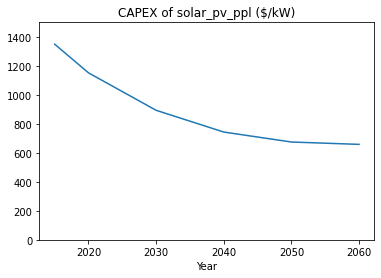

In [21]:
# Visualizing input data in a parameter for certain technologies or commodities
node = "UZB"
tec = "solar_pv_ppl"        # solar PV
parameter = "inv_cost"      # CAPEX
df = base.par(parameter, {"technology": tec, "node_loc": node}).sort_values(["year_vtg"])
df = df.loc[df["year_vtg"] >= 2015]

# Plotting
pl = pd.Series(df["value"].to_list(),
                        index=pd.Index(df["year_vtg"].to_list(), name='Year'))
pl.plot(title='CAPEX of {} ($/kW)'.format(tec), ylim=[0, 1500])

## 4. Solving the scenario
After committing the changes, we are ready to solve the scenario. Solving the scenario means sending the input data from your database to GAMS formulation in the form of GDX files, solving the mathematical formulation, and retrieving the output results (MESSAGEix variables) back to your database. If solving the scenario succeeds without an error, we will be able to look into the results. Otherwise, you need to find out why the scenario has been insolvable.

#### Tip (1): Solver options
Large MESSAGEix models solve more quickly in "Barrier" method when using CPLEX as the solver. You can pass this option through `solve_options` arguments as below.

#### Tipe (2): Case name
You can send your scenario for solving with a user-defined name. This name will be used to name the GDX files in GAMS, and it does not change the model/scenario name in your scenario database. You can leave the case name empty. To be bale to track your scenarios easily in your GAMS folder under `message_ix\model` folder, it is recommended to make a case name with the combination of model, scenario, and version (see below).

In [23]:
# Solving the scenario (may up to 3 minutes)
casename = ('_').join([base.model, base.scenario, str(base.version)])
base.solve(casename, solve_options={'lpmethod': '4'})

ModelError: GAMS errored with return code 6:
    There was a parameter error

For details, see the terminal output above, plus:
Input data: C:\Temp\tmprq_hxnqg\default_in.gdx

In [ ]:
# See the version of this scenario in your database
base.version

## 4.1. Visualizing output results
In this part, we can visualize some output results both on the sub-annual and yearly basis.

In [ ]:
# Monthly results
path = r'C:\Users\zakeri\Documents\Github\central-asia-storage'
node = "TJK"   # Tajikistan
monthly_plot(base, path + "//data//results", node)

In [ ]:
# Yearly results for activity (electricity generation)
yearly_plot(base, path + "//data/results")

In [ ]:
# Close the databse at the end of your work
mp.close_db()